# CAPSTONE PROJECT - HOSPITALS IN LIMA DISTRICT

---

## INTRODUCTION

The coronavirus **COVID-19 pandemic** is the defining global health crisis of our time and one of the greatest challenges we have ever faced. Since its beginnings in Asia, it has spread to most countries in the world, making the presidents order a long quarantine to keep it at bay. Unfortunately, the economy of every nation has plummeted while the positive cases and deaths keep increasing. There doesn’t seem to be a cure in the near future, leaving us with the only option of coexist with the virus. 

**Peru is one of the most affected nations by COVID-19**, being in the top 10 countries with most cases as of June 2, 2020. The Peruvian president Martín Vizcarra declared a national state of emergency on March 15, when the country had just 71 confirmed cases of COVID-19. The order closed Peru’s borders and banned Peruvians from leaving the house except to access essential goods or perform essential work. But public health experts say living and working conditions in the country of 33 million, where a fifth of people live on only around $100 a month, has made it near impossible for many Peruvians to comply with quarantine measures.

### Business Problem

The government of Peru has organized a group of data scientists to analyze the COVID-19 positive cases in the city of Lima and select a district to open a new hospital. Lima is the capital city of Peru, and it holds 60% of the total positive cases in the country. 

**Analyzing the data, which districts would the team recommend opening a new hospital?**

---

## DATA

To solve this problem, the team has set up to find the following data:

 * List of districts in Lima, Peru. This encompass the whole project.
 * Latitude and Longitude of the districts in Lima, Peru. We need this information to plot the map and get the hospitals nearby.
 * COVID-19 positive cases in Lima per district.
 * Hospitals in Lima per district.

For now, we'll set up the packages we need for this project:

In [2]:
import numpy as np
import pandas as pd
import lxml
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import requests

### List of Districts in Lima

The Wikipedia Page https://en.wikipedia.org/wiki/List_of_districts_of_Lima has the data we need in a table format. 

In [3]:
wiki = 'https://en.wikipedia.org/wiki/List_of_districts_of_Lima'
tables = pd.read_html(wiki) #Returns a list
df_dist = tables[0] # tables[0] is a dataframe

In [4]:
df_dist.head()

,Districts,UBIGEO,Area(km²),Population,Population density(/km²),Created,Postalcode,Location
0,Ancón,150102,299.22,29419,98.3,NaN,2,NaN
1,Ate,150103,77.72,419663,5399.7,NaN,3,NaN
2,Barranco,150104,3.33,45922,13790.4,NaN,4,NaN
3,Breña,150105,3.22,94808,29443.5,NaN,5,NaN
4,Carabayllo,150106,346.88,188764,544.2,NaN,6,NaN


In [5]:
df_dist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Districts                 43 non-null     object 
 1   UBIGEO                    43 non-null     int64  
 2   Area(km²)                 43 non-null     float64
 3   Population                43 non-null     int64  
 4   Population density(/km²)  43 non-null     float64
 5   Created                   0 non-null      float64
 6   Postalcode                43 non-null     int64  
 7   Location                  0 non-null      float64
dtypes: float64(4), int64(3), object(1)
memory usage: 2.6+ KB


### Latitude and Longitude of the districts in Lima

This information can be retrieved with Python package Geocoder. This package can be very unreliable, and Google Maps API isn’t really an option since 2018. 

Because of that, we have a CSV file with the correct latitude and longitude of each district, in case the Python package doesn’t work.

In [7]:
df_coords = pd.read_csv("data/Lima_Coords.csv")
df_coords.head()

,PostalCode,Latitude,Longitude
0,1,-12.0464,-77.0428
1,2,-11.7340,-77.1469
2,3,-12.0148,-76.8850
3,4,-12.1412,-77.0221
4,5,-12.0571,-77.0517


In [8]:
df_coords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PostalCode  43 non-null     int64  
 1   Latitude    43 non-null     float64
 2   Longitude   43 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.1 KB


### COVID-19 positive cases in Lima

The government of Peru has the information open to everyone in their webpage: https://www.datosabiertos.gob.pe/dataset/casos-positivos-por-covid-19-ministerio-de-salud-minsa

The dataset they provide is updated every day, and has the positive cases per department, province and district of Peru. The data link is this: https://cloud.minsa.gob.pe/s/Y8w3wHsEdYQSZRp/download

In [9]:
df_covid = pd.read_csv("https://cloud.minsa.gob.pe/s/Y8w3wHsEdYQSZRp/download", usecols=['DEPARTAMENTO','PROVINCIA','DISTRITO'], encoding='latin-1')
df_covid.head()

,DEPARTAMENTO,PROVINCIA,DISTRITO
0,LIMA,LIMA,LA MOLINA
1,AREQUIPA,EN INVESTIGACIÓN,EN INVESTIGACIÓN
2,LIMA,LIMA,SANTIAGO DE SURCO
3,LIMA,LIMA,SANTIAGO DE SURCO
4,LIMA,LIMA,SANTIAGO DE SURCO


In [10]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170039 entries, 0 to 170038
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   DEPARTAMENTO  170039 non-null  object
 1   PROVINCIA     170039 non-null  object
 2   DISTRITO      170039 non-null  object
dtypes: object(3)
memory usage: 1.9+ MB


### Hospitals in Lima per district

To get this data, we are going to use Foursquare API. Using this API, we can make RESTful API calls to retrieve data about hospitals in different districts of Lima. To use it, we need a developer account active. Take into account that the account has a limited amount of normal and premium calls per day

In [74]:
CLIENT_ID = 'your Foursquare ID' # your Foursquare ID
CLIENT_SECRET = 'your Foursquare Secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: your Foursquare ID
CLIENT_SECRET:your Foursquare Secret


To specifically check for Hospitals, we check the foursquare website: https://developer.foursquare.com/docs/build-with-foursquare/categories/

The URL needed is the following: https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}

In [24]:
def getNearbyHospitals(postal, district, latitudes, longitudes, cases, radius=2500, LIMIT=100):
    
    Hospital_category = '4bf58dd8d48988d196941735' #You can get this from the foursquare website
    
    hosp_list=[]
    for post, dist, lat, lng, case in zip(postal, district, latitudes, longitudes, cases):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            Hospital_category,
            radius,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby hospital
        hosp_list.append([(
            post,
            dist,
            lat, 
            lng,
            case,
            v['venue']['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_hospitals = pd.DataFrame([item for hosp_list in hosp_list for item in hosp_list])
    return(nearby_hospitals)

We are defining the function that will allow us to get the data. First we need to manipulate the data in order to pass the correct the data onto the function.

---

## METHODOLOGY

After retrieving the data, we need to start manipulating it to resolve the problem.

### Data Preparation

We'll start first with the data from wikipedia. The steps are:

* Keep columns "Districts", "UBIGEO" and "Postalcode"
* Change column names
* Change the only district "Santa María del Mar District" to the correct name.
* Check data types

In [17]:
# Subset to get "District, UBIGEO and Postalcode"
df_lima = df_dist.loc[:,('Districts','UBIGEO','Postalcode')]
# Renaming columns
df_lima.rename(columns={"Districts":"District","Postalcode":'PostalCode'}, inplace=True)
df_lima.head()

,District,UBIGEO,PostalCode
0,Ancón,150102,2
1,Ate,150103,3
2,Barranco,150104,4
3,Breña,150105,5
4,Carabayllo,150106,6


In [18]:
# Change the only wrong district name
new_val = {'Santa María del Mar District': 'Santa María del Mar'}
df_lima['District'].replace(new_val,inplace = True)
df_lima

,District,UBIGEO,PostalCode
0,Ancón,150102,2
1,Ate,150103,3
2,Barranco,150104,4
3,Breña,150105,5
4,Carabayllo,150106,6
5,Chaclacayo,150107,8
6,Chorrillos,150108,9
7,Cieneguilla,150109,40
8,Comas,150110,7
9,El Agustino,150111,10


In [19]:
# Check data types
df_lima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   District    43 non-null     object
 1   UBIGEO      43 non-null     int64 
 2   PostalCode  43 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 924.0+ bytes


Now that we have our dataframe "df_lima" with the districts from Lima, we need to merge to have the columns "Latitude" and "Longitude". The steps are:

* Merge the district dataframe with the coordinates dataframe
* Check everything went smoothly

In [20]:
# Creating a new dataframe with the merge
df_limacoords = pd.merge(df_lima, df_coords, on='PostalCode')
df_limacoords.head()

,District,UBIGEO,PostalCode,Latitude,Longitude
0,Ancón,150102,2,-11.7340,-77.1469
1,Ate,150103,3,-12.0148,-76.8850
2,Barranco,150104,4,-12.1412,-77.0221
3,Breña,150105,5,-12.0571,-77.0517
4,Carabayllo,150106,6,-11.8819,-77.0234


Now we have a complete dataframe with the coordinates for each district in Lima. The next phase is to add the data for COVID-19 positive cases per district. The steps are:

* Subset the dataframe for 'DEPARTAMENTO' == 'LIMA' and 'PROVINCIA' == 'Lima'. This will give us the 43 districts of Lima.
* Drop the columns 'DEPARTAMENTO' and 'PROVINCIA'
* Count the districts to get the number of COVID-19 positive cases per District
* Rename the columns
* Sort the values to easily concat the data with the first dataframe
* Concat to the desired dataframe
* Drop the column "Districts"

In [21]:
# Subset dataframe based on condition
df_covid = df_covid.loc[(df_covid['DEPARTAMENTO']=='LIMA') & (df_covid['PROVINCIA'] == 'LIMA')]
# Dropping unneeded columns
df_covid.drop(['DEPARTAMENTO','PROVINCIA'], inplace = True, axis = 1)
df_covid.head()

,DISTRITO
0,LA MOLINA
2,SANTIAGO DE SURCO
3,SANTIAGO DE SURCO
4,SANTIAGO DE SURCO
5,SANTIAGO DE SURCO


In [22]:
# Group by to count the cases
df_covid = df_covid.groupby(['DISTRITO']).size().reset_index(name='PositiveCases')
# Renaming the column
df_covid.rename(columns = {'DISTRITO':'Districts'}, inplace = True)
# Sorting the values
df_covid.sort_values(by=['Districts'], inplace=True)

df_covid.head()

,Districts,PositiveCases
0,ANCON,328
1,ATE,5601
2,BARRANCO,441
3,BREÑA,1196
4,CARABAYLLO,2036


In [23]:
# Concat the dataframes
df_final = pd.concat([df_limacoords, df_covid], axis=1)
# Drop the column "Districts"
df_final.drop(df_final.columns[5], axis=1, inplace=True)

df_final.head()

,District,UBIGEO,PostalCode,Latitude,Longitude,PositiveCases
0,Ancón,150102,2,-11.7340,-77.1469,328
1,Ate,150103,3,-12.0148,-76.8850,5601
2,Barranco,150104,4,-12.1412,-77.0221,441
3,Breña,150105,5,-12.0571,-77.0517,1196
4,Carabayllo,150106,6,-11.8819,-77.0234,2036


Great! We have an almost completed dataframe. The next thing missing is the hospitals data. To get it, we are going to use the **Foursquare API**. In the **Data Chapter**, we setup a function to get this data. The steps are:

* Call the function and save it in a dataframe
* Check for duplicate hospitals in the dataframe
* Check for wrong names in the dataframe
* Check that the hospitals belong to the respective district
* Check that the hospitals retrieved are actually hospitals
* Check that the hospitals have specializations in regards to COVID-19
* Finally, rename the columns

The process to check all of this takes a long time.

In [26]:
# Calling the function and saving the data
lima_hospitals = getNearbyHospitals(postal=df_final['PostalCode'],
                                    district=df_final['District'],
                                    latitudes=df_final['Latitude'],
                                    longitudes=df_final['Longitude'],
                                    cases=df_final['PositiveCases'])
print(lima_hospitals.shape)
lima_hospitals.head()

(448, 9)


,0,1,2,3,4,5,6,7,8
0,3,Ate,-12.0148,-76.8850,5601,3B SALUD E.I.R.L.,-12.012660,-76.877576,Hospital
1,4,Barranco,-12.1412,-77.0221,441,EsSalud,-12.147275,-77.018664,Hospital
2,4,Barranco,-12.1412,-77.0221,441,Instituto Neuro Cardiovascular de las Américas...,-12.130236,-77.019267,Hospital
3,4,Barranco,-12.1412,-77.0221,441,Hospital de Emergencias José Casimiro Ulloa,-12.127918,-77.018019,Hospital
4,4,Barranco,-12.1412,-77.0221,441,Clínica Caravedo,-12.155737,-77.021910,Hospital


In [28]:
# Dataframe with all duplicate values
lima_hospitals_dups = lima_hospitals[lima_hospitals.duplicated([5], keep=False)].sort_values(by=[5])

In [30]:
# Checking out the data
lima_hospitals_dups.head(15)

,0,1,2,3,4,5,6,7,8
365,27,San Isidro,-12.0998,-77.0363,898,12C Infectología,-12.078357,-77.040320,Hospital Ward
210,14,Lince,-12.0848,-77.0356,709,12C Infectología,-12.078357,-77.040320,Hospital Ward
116,11,Jesús María,-12.0825,-77.0506,3047,12C Infectología,-12.078357,-77.040320,Hospital Ward
355,27,San Isidro,-12.0998,-77.0363,898,Banco De Sangre - Hospital Nacional Edgardo Re...,-12.079133,-77.041578,Hospital
85,11,Jesús María,-12.0825,-77.0506,3047,Banco De Sangre - Hospital Nacional Edgardo Re...,-12.079133,-77.041578,Hospital
189,14,Lince,-12.0848,-77.0356,709,Banco De Sangre - Hospital Nacional Edgardo Re...,-12.079133,-77.041578,Hospital
250,18,Miraflores,-12.1111,-77.0316,1211,Centro Medico Naval (CEMENA),-12.121735,-77.034348,Hospital
359,27,San Isidro,-12.0998,-77.0363,898,Centro Medico Naval (CEMENA),-12.121735,-77.034348,Hospital
92,11,Jesús María,-12.0825,-77.0506,3047,Centro Quirúrgico,-12.078664,-77.039437,Hospital
187,14,Lince,-12.0848,-77.0356,709,Centro Quirúrgico,-12.078664,-77.039437,Hospital


In [32]:
# Checking out the hospital names we need to fix
lima_hospitals_dups[5].unique()

array(['12C Infectología',
       'Banco De Sangre - Hospital Nacional Edgardo Rebagliati Martins',
       'Centro Medico Naval (CEMENA)', 'Centro Quirúrgico',
       'Centro de Salud Max Arias',
       'Centro de Vacunación - Clínica Javier Prado',
       'Centro de salud Militar - San Francisco', 'Clinica Continental',
       'Clinica Libertadores', 'Clinica Pinel', 'Clinica Providencia',
       'Clinica Santa Teresa', 'Clinica Sonreir',
       'Clinica Virgen Del Rosario',
       'Clinica Virgen de las Mercedes (Hosp. Militar Central',
       'Clínica Anglo Americana', 'Clínica Cayetano Heredia',
       'Clínica Centenario Peruano Japonesa', 'Clínica Concebir',
       'Clínica De La Mujer', 'Clínica Delgado', 'Clínica Detecta',
       'Clínica El Golf | Sanna', 'Clínica González', 'Clínica Good Hope',
       'Clínica Good Hope - Centro Vacunacion Internacional',
       'Clínica Hogar de la Madre', 'Clínica Internacional',
       'Clínica Internacional - Sede Rehabilitación',
       

In [33]:
# Setting up a list of "Hospitals" that are not Hospitals or dont have any specialization to help with COVID-19
Not_hospitals = ['Banco De Sangre - Hospital Nacional Edgardo Rebagliati Martins',
                 '12C Infectología',
                 'Centro Medico Naval (CEMENA)',
                 'Centro Quirúrgico',
                 'Centro de Vacunación - Clínica Javier Prado',
                 'Clinica Continental',
                 'Clinica Santa Teresa',
                 'Clinica Sonreir',
                 'Clínica Cayetano Heredia',
                 'Clínica Concebir',
                 'Clínica Miraflores (Instituto de Ginecología y Fertilidad)',
                 'Clínica De La Mujer',
                 'INCOR -  Instituto Nacional Cardiovascular',
                 'RENIEC',
                 'Pediatría',
                 'Instituto Nacional Materno Perinatal - Maternidad de Lima',
                 'Instituto Nacional de Enfermedades Neoplásicas - INEN',
                 'Instituto Nacional de Oftalmología - INO',
                 'Instituto Neuro Cardiovascular de las Américas - INCA',
                 'Municipalidad de San Isidro',
                 'Clínica Detecta',
                 'Clínica Internacional - Sede Rehabilitación',
                 'Direccion De Examenes Clinicos Forense',
                 'Emergencia - Salud Mental',
                 'Emergencia Adultos',
                 'Farmacia Universal',
                 'Pabellon Medicina E1 - HNHU',
                 'Fopasef',
                 'Red Salud',
                 'Resomasa',
                 'Resomasa Clinica Angloamericana',
                 'Rimac Seguros',
                 'Neoplasicas',
                 'Neurología',
                 'Instituto Peruano de Ortopedia y Traumatología - Clínica Ricardo Palma (IPOT CRP)',
                 'Clínica Good Hope - Centro Vacunacion Internacional',
                 'Consultorio Virgen de las Nieves',
                 'Hibu Perú',
                 'Hospital a Domicilio HD+',
                 'Clínica Hogar de la Madre',
                 'Clínica Oncosalud',
                 'Clínica san jose marello',
                 'OPELUCE',
                 'Policlinico Club de Leones Salamanca de Monterrico',
                 'Policlínico Pizarro',
                 'SISOL',
                 'SISOL Comas',
                 'UCI Clinica Centenario Peruano Japonesa']

In [34]:
# Setting up a list of wrongly assignated Hospitals.
wrong_dist = [32,166,388,249,199,285,286,396,279,280,229,240,232,15,81,432,336,106,238,205,
              352,112,151,12,134,426,381,19,124,325,254,265,330,109,257,207,417,34,193,383,121,
              180,271,225,327,164,110,33,194,148,135,379,433,139,382,331,107,266,96,239,22,
              410,8,430,208,23,61,267,100,344,142,340,420,292,423,196,323,228,274,175,337,
              278,230,227,277,75,10,14,18,400,99,25,237,30,339,419,114,31,140,3,424,29,144,343,101,
              244,338,76,26,60,13,411,377,203,104,165,36,299,169,375,21,284,200,111,234,
              421,335,213,102,143,342,431,385,141,178,89,347,113,281,252,349]

In [35]:
# Changing the names of some hospitals that had the wrong name
lima_hospitals.loc[[158],[5]] = 'Clínica Internacional - Sede Lima'
lima_hospitals.loc[[305],[5]] = 'Clínica Internacional - Sede San Borja'
lima_hospitals.loc[[162],[5]] = 'Clínica Maison de Santé de Lima'
lima_hospitals.loc[[407],[5]] = 'Clínica Maison de Santé del Este'
lima_hospitals.loc[[6],[5]] = 'Clínica Maison de Santé del Sur'
lima_hospitals.loc[[155],[5]] = 'SISOL Salud Camana'
lima_hospitals.loc[[181],[5]] = 'SISOL Salud Lince'
lima_hospitals.loc[[409],[5]] = 'SISOL Salud Surquillo'
lima_hospitals.loc[[296],[5]] = 'SISOL Salud Metro UNI'
lima_hospitals.loc[[42],[5]] = 'SISOL Salud Carabayllo'
lima_hospitals.loc[[63],[5]] = 'SISOL Salud El Agustino'
lima_hospitals.loc[[302],[5]] = 'Instituto Nacional de Salud del Niño San Borja'
lima_hospitals.loc[[177],[5]] = 'Policlínico Risso'
lima_hospitals.loc[[226],[5]] = 'SISOL Salud Magdalena'
lima_hospitals.loc[[412],[5]] = 'ESSALUD Surquillo'

In [37]:
# Dropping the rows that dont satisfy our conditions
lima_hospitals.drop(lima_hospitals[lima_hospitals[5].isin(Not_hospitals)].index, axis=0, inplace=True)
lima_hospitals.drop(wrong_dist, axis=0, inplace=True)

In [38]:
# Generating a new duplicate dataframe just to check
lima_hospitals_dups = lima_hospitals[lima_hospitals.duplicated([5], keep=False)].sort_values(by=[5])
lima_hospitals_dups.head()

,0,1,2,3,4,5,6,7,8


Nice! Now we dont have any more duplicate **"Hospitals"** in our dataframe. Our work is not over though. Checking up the data further, we found more **"Hospitals"** that are'nt hospitals. We'll remove them.

In [39]:
Not_hospitals_2 = ['Torre de Consultas Externas - HNGAI',
                   'Hospital Guillermo Almenara - Neurocirugía',
                   'Sala San Andrés',
                   'Sala Julian Arce del HNDM',
                   'Laboratorio Oswaldo Hercelles del HNDM',
                   'Servicio De Traumatologia - Emergencias Hospital Dos De Mayo',
                   'Consultorios Externos HNHU',
                   'Hospital Hipolito Unanue SOP',
                   'Patología HNHU',
                   'Oftalmologia - Hospital Sergio Bernales',
                   'Hospital Puente Piedra',
                   'Hospital de la Solidaridad',
                   'Clinica Virgen de las Mercedes (Hosp. Militar Central',
                   'Hospital Solidaridad Camana',
                   'Hospital de la solidaridad',
                   'VillaSalud',
                   'Complejo Hospitalario Guillermo Kaelin']

In [40]:
lima_hospitals.drop(lima_hospitals[lima_hospitals[5].isin(Not_hospitals_2)].index, axis=0, inplace=True)
lima_hospitals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148 entries, 0 to 446
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       148 non-null    int64  
 1   1       148 non-null    object 
 2   2       148 non-null    float64
 3   3       148 non-null    float64
 4   4       148 non-null    int64  
 5   5       148 non-null    object 
 6   6       148 non-null    float64
 7   7       148 non-null    float64
 8   8       148 non-null    object 
dtypes: float64(4), int64(2), object(3)
memory usage: 9.8+ KB


In [41]:
# Finally, we just need to rename the columns:
lima_hospitals.columns = ['PostalCode','District','DistLatitude','DistLongitude','CovidCases','Hospital','HospLatitude',
                     'HospitalLongitude','Category']
lima_hospitals.head()

,PostalCode,District,DistLatitude,DistLongitude,CovidCases,Hospital,HospLatitude,HospitalLongitude,Category
0,3,Ate,-12.0148,-76.8850,5601,3B SALUD E.I.R.L.,-12.012660,-76.877576,Hospital
1,4,Barranco,-12.1412,-77.0221,441,EsSalud,-12.147275,-77.018664,Hospital
4,4,Barranco,-12.1412,-77.0221,441,Clínica Caravedo,-12.155737,-77.021910,Hospital
6,4,Barranco,-12.1412,-77.0221,441,Clínica Maison de Santé del Sur,-12.157053,-77.022743,Hospital
9,4,Barranco,-12.1412,-77.0221,441,Policlinico Militar de Chorrillos,-12.160113,-77.019408,Hospital


### Data Analysis

After all our work preparing the data, we can finally start analyzing.

For now, I would start analyzing the Lima districts and their hospitals in a map plot.

In [47]:
# With this part, we now now the coordinates of the city Lima
address = 'Lima'

geolocator = Nominatim(user_agent="lima_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Lima City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Lima City are -12.0621065, -77.0365256.


In [49]:
map_lima = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, dist, case in zip(df_final['Latitude'], df_final['Longitude'], df_final['District'], df_final['PositiveCases']):
    label_1 = '{} district, {} positive cases'.format(dist, case)
    label_1 = folium.Popup(label_1, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label_1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lima)

for lat, lng, dist, name in zip(lima_hospitals['HospLatitude'], lima_hospitals['HospitalLongitude'], lima_hospitals['District'], lima_hospitals['Hospital']):
    label_2 = '{} district, {}'.format(dist, name)
    label_2 = folium.Popup(label_2, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label_2,
        color='red',
        fill=True,
        fill_color='#c91c33',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lima)

map_lima

The maps is very interesting. We can see a few things from this:

* The agglomeration of hospitals seems to be in the center of Lima.
* As you progressively leave from the center, there’s less hospitals.
* Districts in the outskirts of the city have little to no hospitals.

OK! Now we can move on to evaluate the quantity of hospitals and CovidCases per district. We'll use horizontal bar charts for that. To create them, we first need to modify our dataframe slightly:
* Group the dataframe by 'District' and 'CovidCases' to count the hospitals
* Add the districts with no hospitals at the bottom.

In [51]:
# Grouping to get the amount of hospitals
df_final_count = lima_hospitals.groupby(['District','CovidCases']).size().reset_index(name='Hospitals')
df_final_count

,District,CovidCases,Hospitals
0,Ate,5601,1
1,Barranco,441,4
2,Breña,1196,2
3,Carabayllo,2036,4
4,Chaclacayo,438,7
5,Chorrillos,2839,6
6,Comas,5262,3
7,El Agustino,4429,8
8,Independencia,2303,1
9,Jesús María,3047,6


In [52]:
# Getting the districts that didnt appear in the dataframe
df_append_count = df_final.groupby(['District','PositiveCases']).size().reset_index(name='Hospitals')
df_append_count['Hospitals'] = 0
df_append_count.columns = ['District','CovidCases','Hospitals']
df_append_count[df_append_count['District'].isin(df_final_count['District']) == False]

,District,CovidCases,Hospitals
0,Ancón,328,0
7,Cieneguilla,107,0
22,Pucusana,190,0
25,Punta Hermosa,42,0
26,Punta Negra,34,0
28,San Bartolo,40,0
37,Santa María del Mar,9,0
38,Santa Rosa,61,0


In [53]:
# Appending the dataframe
df_count = df_final_count.append(df_append_count[df_append_count['District'].isin(df_final_count['District']) == False], ignore_index = True)
df_count.tail(10)

,District,CovidCases,Hospitals
33,Villa El Salvador,4116,4
34,Villa María del Triunfo,2861,2
35,Ancón,328,0
36,Cieneguilla,107,0
37,Pucusana,190,0
38,Punta Hermosa,42,0
39,Punta Negra,34,0
40,San Bartolo,40,0
41,Santa María del Mar,9,0
42,Santa Rosa,61,0


Great! Lets start plotting. What we want is:
* Covid Positive Cases per Districts in Lima
* Hospitals per District

In [54]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.2.1


In [55]:
# We are setting up the data for the plots
plt_districts = df_count.set_index('District')
plt_hosp = plt_districts.drop(['CovidCases'],axis=1)
plt_covid = plt_districts.drop(['Hospitals'],axis=1)
plt_covid.sort_values(by='CovidCases', ascending=True, inplace=True)
plt_hosp.sort_values(by='Hospitals', ascending=True, inplace=True)

Text(0.5, 0, 'Quantity of Covid Positive Cases')

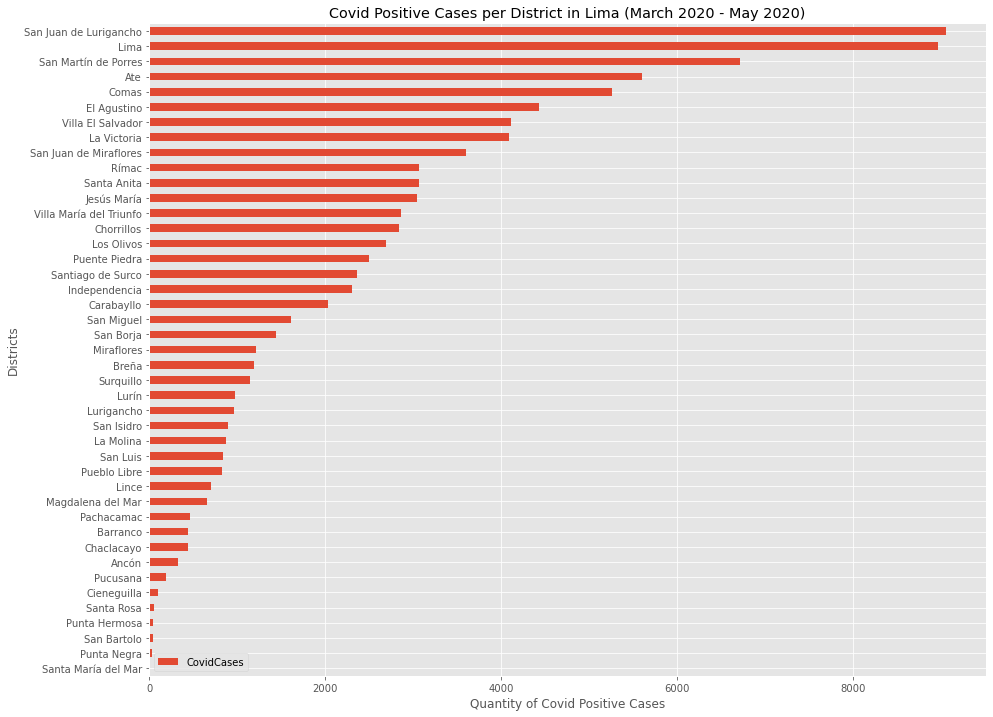

In [61]:
ax1 = plt_covid.plot(kind='barh', figsize=(15,12))

ax1.set_title('Covid Positive Cases per District in Lima (March 2020 - May 2020)')
ax1.set_ylabel('Districts')
ax1.set_xlabel('Quantity of Covid Positive Cases')

Text(0.5, 0, 'Quantity of Hospitals')

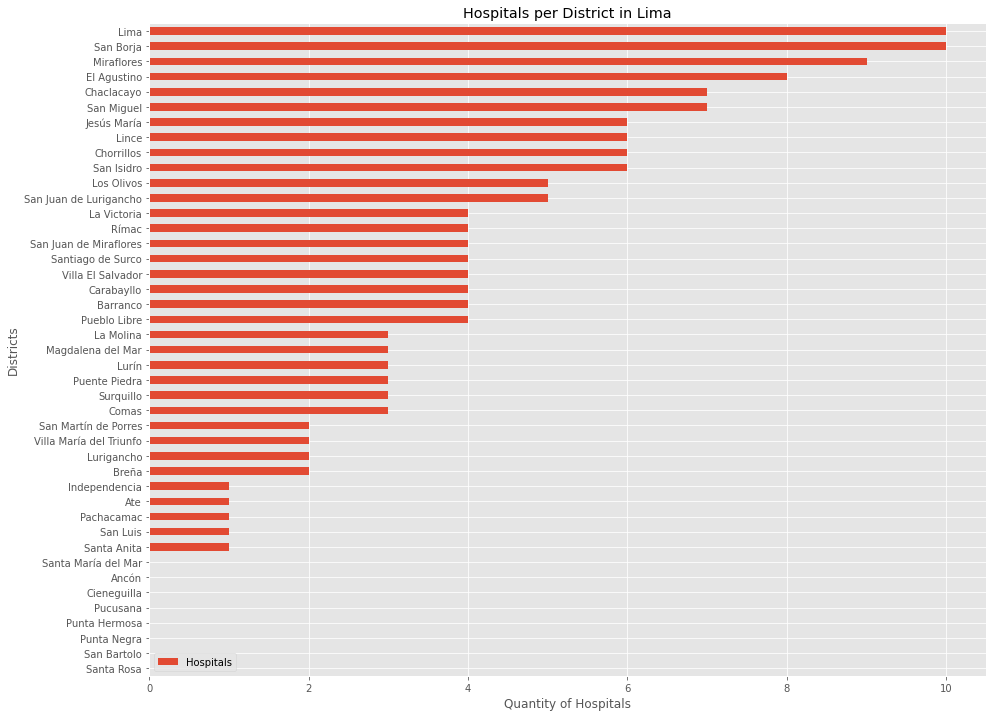

In [63]:
ax2 = plt_hosp.plot(kind='barh', figsize=(15,12))

ax2.set_title('Hospitals per District in Lima')
ax2.set_ylabel('Districts')
ax2.set_xlabel('Quantity of Hospitals')

Interesting, we can see something here:
* San Juan de Lurigancho and Lima have the most amount of COVID-19 cases.
* Santa Maria del Mar, Punta Negra, San Bartolo, Punta Hermosa and Santa Rosa have the least amount of COVID-19 cases.
* Lima, San Borja and Miraflores have the most hospitals than any other district
* Santa Maria del Mar, Punta Negra, San Bartolo, Punta Hermosa, Santa Rosa, Ancon, Cieneguilla, and Pucusana have no hospitals.

* Lima has both the most COVID-19 cases and a large number of hospitals.
* Santa Maria del Mar, Punta Negra, San Bartolo, Punta Hermosa and Santa Rosa have no hospitals. But, at the same time, they have little to no cases of COVID-19.

### Machine Learning

For our machine learning part, we are going to do a basic **Content-Based** machine learning. This will help us recommend the most needed district. The steps are:

* Import from sklearn MinMaxScaler
* Normalize the values of the dataframe
* Turn it into a dataframe

In [64]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [65]:
# Normalizing the dataframe
count_normalized = scaler.fit_transform(plt_districts)

In [66]:
# Save it into a datframe
df_count_normalized = pd.DataFrame(count_normalized, index=plt_districts.index, columns=plt_districts.columns)

In [67]:
df_count_normalized.head()

,CovidCases,Hospitals
District,,
Ate,0.618105,0.1
Barranco,0.047751,0.4
Breña,0.131204,0.2
Carabayllo,0.224052,0.4
Chaclacayo,0.047419,0.7


---

## RESULTS

Now that we have our normalized dataframe ready, we can start with our final plot to make our decision. The steps are:
* Sort the values of our normalized dataframe
* Set up a condition. In this case we want the most amount of cases with the least amount of Hospitals per district.
* Create the bar plot

In [68]:
# Sorting the values
df_count_normalized.sort_values(by="CovidCases", ascending=False, axis=0, inplace=True)
# Setting up our condition
df_count_normalized_plot = df_count_normalized[(df_count_normalized['CovidCases'] >= 0.5) & 
                                               (df_count_normalized['Hospitals'] <= 0.5)]

In [69]:
df_count_normalized_plot

,CovidCases,Hospitals
District,,
San Juan de Lurigancho,1.000000,0.5
San Martín de Porres,0.741461,0.2
Ate,0.618105,0.1
Comas,0.580634,0.3


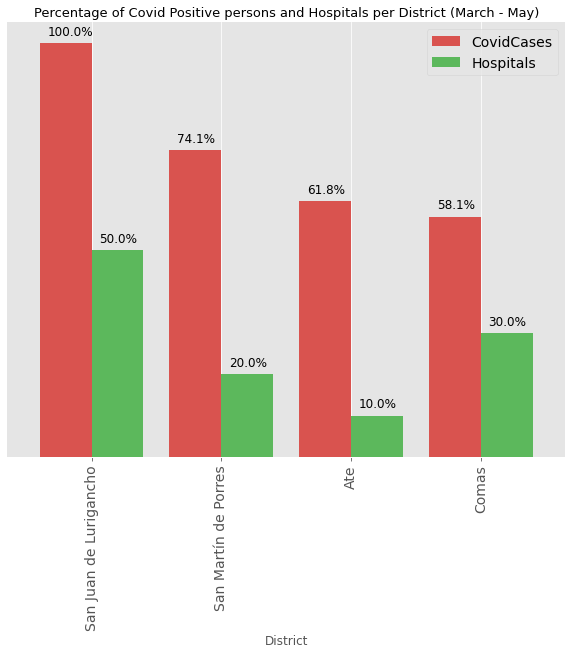

In [71]:
# Creating our plot

colors_list = ['#d9534f', '#5cb85c']
ax3 = df_count_normalized_plot.plot(kind="bar", figsize=(10,8), width = 0.8, color=colors_list)

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(True)
ax3.spines['left'].set_visible(False)
ax3.get_yaxis().set_ticks([])
ax3.set_title('Percentage of Covid Positive persons and Hospitals per District (March - May)', fontsize=13)
ax3.legend(fontsize=14)
ax3.tick_params(axis="x", labelsize=14)

for index, value in enumerate(df_count_normalized_plot.loc[:,"CovidCases"]):
    ax3.text(index-0.34, value+0.02, str('{:.1%}'.format(value)), fontsize=12)
    
for index, value in enumerate(df_count_normalized_plot.loc[:,"Hospitals"]):
    ax3.text(index+0.06, value+0.02, str('{:.1%}'.format(value)), fontsize=12)

Now that we have our plot, we can answer the question.

**Q: Analyzing the data, which districts would the team recommend opening a new hospital?**

**A: The district that need new hospitals amidst this pandemic are San Juan de Lurigancho, San Martin de Porres, Ate and Comas.**

The reason we can give for this decision is:
* These four districts are among the top 5 most positive COVID-19 cases
* Lima has the same amount of positive cases as San Juan de Lurigancho, but also has the most amount of hospitals.
* The difference between COVID-19 cases and hospitals within these districts is about 30%to 50%
* If Lima is the example, these 4 districts need more hospitals to help defeat COVID-19.

---

## DISCUSSION

Regarding the Foursquare API, it did bring me the venues from the right category (Hospitals). However, the data was very messy and had to clean it a lot. Most of the hospitals also had their old names from before 2015. This makes me think that, at least in Lima, the app is not really being used as much as other countries. What’s more interesting was that some hospitals retrieved had 2 to 3 different names in their database pointing to the same location. Those were hard to track, but they were also removed. The data used here is probably outdated and not so reliable.

Regarding COVID-19, the amount of cases keeps increasing by the day, so by the end of June the data will be outdated. This is a project that constantly needs to have new data to be relevant. The best way is to create a python file and call it every day to get updated data on this statistic. Even so, the data from the government of Peru might also be unreliable. This has been called out recently, because some statisticians in Peru have found out inconsistencies with our positive cases and deaths. Further investigation will be necessary to trust 100% this data.

---

## CONCLUSION

The government of Peru now has the answer to their problem. The 4 districts of Lima, Peru have been set as a priority to build new hospitals and fight the pandemic. This was made possible by having the COVID-19 data and hospitals by district. In our case, **Content-Based Filtering** was the best choice.

This project has a lot of room for improvement. We can aggregate a lot more factors to do our decision like Pharmacies, population, transit of people, and much more. Considering my current level of expertise in Python programming, I feel satisfied with this project. I learned a lot about my city and how we are currently facing this pandemic.